# Chapter 3 classification

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

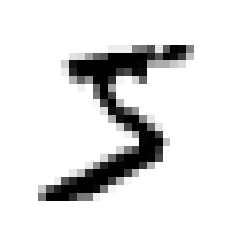

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
import numpy as np
y = y.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training a binary classifier
for the moment, only build a number 5 classificator

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
#if you want change the value of the classifier change the number after ==

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#some digit is a number five
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

### Measuring accuracy using cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_fold,y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9676135667931921
0.9631421049409171
0.9610604298046899


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.96761357, 0.9631421 , 0.96106043])

In [ ]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91122811, 0.91024307, 0.90926345])

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
#y_pred = sgd_clf.predict(X_train)
confusion_matrix(y_train_5, y_train_predict)

array([[43846,   756],
       [ 1011,  3387]])

In [ ]:
y_train_perfect = y_train_5
confusion_matrix(y_train_5,y_train_perfect)

array([[44602,     0],
       [    0,  4398]])

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(f'precision:{precision_score(y_train_5,y_train_predict)}')
print(f'recall:{recall_score(y_train_5,y_train_predict)}')

precision:0.8175235336712527
recall:0.7701227830832197


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_predict)

0.793115560238848

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[3675.34508758]
[ True]


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')
y_scores

array([-24865.08827364, -50292.78283928, -25793.36502201, ...,
       -10671.00799625, -12738.39920658, -27111.60240149])

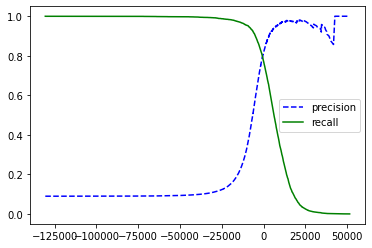

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions , recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--',label='precision')
    plt.plot(thresholds, recalls[:-1],'g-',label='recall')
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.show()

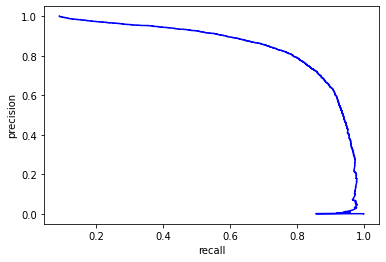

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions[:-1], recalls[:-1],'b-')
    plt.xlabel('recall')
    plt.ylabel('precision')

plot_precision_vs_recall(precision,recall)
plt.show()

In [ ]:
threshold_90_precision = threshold[np.argmax(precision >= 0.90)]
threshold_90_precision

3201.7233692626583

In [ ]:
y_train_pred_90 =  (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9000636537237429
0.6430195543428832


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate(recall)')


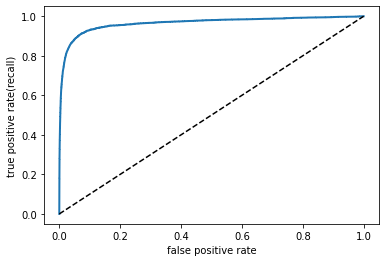

In [ ]:
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9644408219519376

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, #cv is the number of folds
                                    method='predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

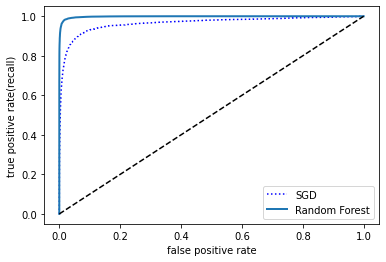

In [ ]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

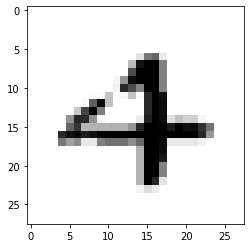

In [ ]:
some_digit_2 = X_test[9]
some_digit_2_image = some_digit_2.reshape(28,28)
plt.imshow(some_digit_2_image,cmap='binary')

In [ ]:
svm_clf.predict([some_digit_2])

array([4], dtype=uint8)

In [ ]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.7207467 ,  1.72604112,  7.24850305,  8.30569427, -0.31062893,
         9.31328015,  2.71434118,  2.7962347 ,  6.21022397,  4.92387044]])

Using a simple scale of the features can improve the accuracy of the learning algoithm

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90730991, 0.9024674 , 0.8986714 ])

In [ ]:
y_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, )
conf_mx = confusion_matrix(y_train,y_pred)
conf_mx

array([[4593,    0,   15,    7,    6,   32,   33,    5,  152,    2],
       [   1, 5265,   35,   11,    2,   29,    8,   10,  141,   11],
       [  23,   20, 4289,   66,   55,   21,   53,   36,  284,   10],
       [  19,   15,   95, 4263,    1,  169,   22,   37,  289,   55],
       [  10,   12,   44,    5, 4399,    9,   27,   28,  207,  147],
       [  27,   16,   22,  114,   44, 3648,   73,   16,  372,   66],
       [  28,   16,   41,    1,   35,   70, 4485,    6,  106,    0],
       [  14,   14,   49,   18,   37,    7,    3, 4590,  105,  208],
       [  14,   54,   41,   68,    3,  110,   23,    6, 4466,   48],
       [  16,   17,   18,   52,  125,   35,    1,  130,  234, 4240]])

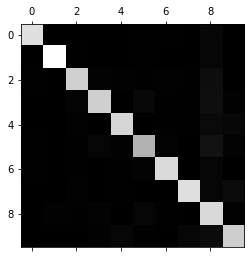

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

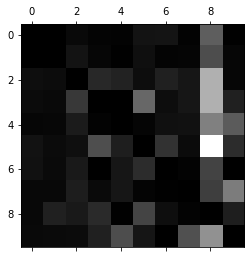

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Multilabel classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

multioutput


In [ ]:
noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

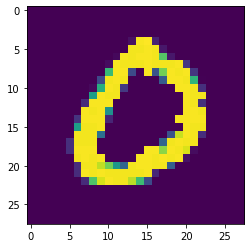

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
plt.imshow(clean_digit.reshape(28,28))